## 1. Enunciado

En esta práctica se aplican los conocimientos adquiridos sobre el uso de librerías de visualización en Python para el análisis y la comunicación de datos deportivos.

Para ello, se deben realizar los siguientes pasos:

1. **Obtención de los datos**  
   Buscar un conjunto de datos (dataset) disponible en internet —por ejemplo, en plataformas como Kaggle— que contenga información detallada sobre un partido de fútbol.  
   En caso de no encontrar un dataset adecuado, se permite generar un fichero propio de *eventing* que recoja los eventos relevantes del partido.

2. **Análisis visual del partido**  
   Desarrollar un script en Python que utilice dicho fichero de datos para explicar qué ha ocurrido en el partido **exclusivamente mediante visualizaciones gráficas**.  
   Se puede emplear cualquier librería de visualización (por ejemplo, Matplotlib, Seaborn, Plotly) o una combinación de varias de ellas.

   El análisis debe incluir **al menos seis (6) gráficas distintas**.

3. **Claridad y capacidad explicativa**  
   Las visualizaciones deben ser lo suficientemente claras y explicativas como para que cualquier persona que las observe pueda comprender el desarrollo y los aspectos clave del partido sin necesidad de texto adicional.

---

## 2. Detalles de la entrega

Se deberá entregar un script que cumpla todos los puntos definidos en el enunciado anterior, siguiendo una de las siguientes modalidades:

- **a. Uso de Jupyter Notebook**  
  En caso de utilizar un notebook de Jupyter:
  - Convertir el notebook a formato **HTML**.
  - Subir a la plataforma tanto el archivo **`.ipynb`** como el **HTML** generado.
  - El notebook debe mostrar por pantalla todas las gráficas producidas.

- **b. Uso de IDE o editor de código**  
  En caso de desarrollar el proyecto mediante un IDE o editor de código:
  - Subir al campus virtual un **archivo ZIP** que contenga:
    - El script en Python.
    - Todas las imágenes generadas, **numeradas según el orden de lectura recomendado**.


## Extracción de estadísticas del partido desde la web

Este bloque de código utiliza **Selenium** para acceder automáticamente a una página web del diario *Marca* y extraer las estadísticas oficiales de un partido de fútbol.  
Debido a que los datos están encapsulados dentro de un **Shadow DOM**, se emplea JavaScript para acceder a su contenido.

El script obtiene:
- Nombres de los equipos (local y visitante).
- Goles y posesión de cada equipo.
- Estadísticas detalladas organizadas por secciones (generales, ataque, defensa, etc.).

Toda la información extraída se almacena en estructuras de datos de Python para su posterior uso en la generación de gráficas e infografías del partido.


In [36]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service

URL = "https://www.marca.com/futbol/primera-division/cronica/2026/01/18/barca-da-vidilla-arbeloa.html"

options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--window-size=1920,1080")

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=options
)

driver.get(URL)

wait = WebDriverWait(driver, 20)

# Esperar al componente
component = wait.until(
    EC.presence_of_element_located((By.CSS_SELECTOR, "ue-football-match-stats"))
)

# Entrar en el Shadow DOM
shadow_root = driver.execute_script(
    "return arguments[0].shadowRoot", component
)

# =============================
# EQUIPOS
# =============================

home_team = shadow_root.find_element(By.ID, "home-team-title").text
away_team = shadow_root.find_element(By.ID, "away-team-title").text

# =============================
# GOLES
# =============================

goals = shadow_root.find_elements(
    By.CSS_SELECTOR,
    ".ue-c-football-match-stats__goals span.is-home-team, \
     .ue-c-football-match-stats__goals span.is-away-team"
)

home_goals = goals[0].text
away_goals = goals[1].text

# =============================
# POSESIÓN
# =============================

possession_home = shadow_root.find_element(
    By.CSS_SELECTOR, ".ue-c-football-match-stats__home-possession"
).text

possession_away = shadow_root.find_element(
    By.CSS_SELECTOR, ".ue-c-football-match-stats__away-possession"
).text

# =============================
# LISTAS DE ESTADÍSTICAS
# =============================

stats = {}

sections = shadow_root.find_elements(
    By.CSS_SELECTOR, "div.ue-c-football-match-stats__title.to_uppercase"
)

lists = shadow_root.find_elements(
    By.CSS_SELECTOR, "ul.ue-c-football-match-stats__list"
)

for section, ul in zip(sections, lists):
    section_name = section.text.upper()

    items = ul.find_elements(By.CSS_SELECTOR, "li")

    for item in items:
        name = item.find_element(By.TAG_NAME, "span").text

        values = item.find_elements(By.CSS_SELECTOR, ".is-home-team, .is-away-team")
        home_val = values[0].text
        away_val = values[1].text

        stats[f"{section_name} - {name}"] = (home_val, away_val)

driver.quit()

# =============================
# RESULTADO FINAL
# =============================

print("Equipo local:", home_team)
print("Equipo visitante:", away_team)
print("Goles:", home_goals, "-", away_goals)
print("Posesión:", possession_home, "/", possession_away)

for k, v in stats.items():
    print(k, "→", v)


Equipo local: R. Sociedad
Equipo visitante: Barcelona
Goles: 2 - 1
Posesión: 28% / 72%
ATAQUE - Duelos ganados → ('41', '65')
ATAQUE - Remates → ('7', '25')
ATAQUE - Remates a portería → ('6', '9')
ATAQUE - Corners → ('6', '8')
ATAQUE - Fueras de juego → ('4', '3')
ATAQUE - Pases → ('148', '535')
DEFENSA - Balones perdidos → ('132', '126')
DEFENSA - Balones recuperados → ('43', '53')
DEFENSA - Paradas portero → ('8', '3')
AMONESTACIONES - Faltas cometidas → ('13', '8')
AMONESTACIONES - Tarjetas amarillas → ('3', '4')
AMONESTACIONES - Tarjetas rojas → ('1', '0')


## Generación de la infografía de estadísticas del partido

Este bloque de código se encarga de **crear una infografía visual** que resume las estadísticas principales del partido utilizando la librería **Matplotlib**.

En primer lugar, se definen los **colores y estilos visuales** de cada equipo, así como el fondo y el color del texto, con el objetivo de mantener una estética clara y coherente.  
A continuación, se descargan y cargan los **escudos de ambos equipos** directamente desde la web para incorporarlos a la visualización.

Las estadísticas extraídas previamente se organizan en distintas **secciones** (generales, ataque, defensa y amonestaciones), estructurando los datos para facilitar su representación gráfica.

Finalmente, se genera una figura personalizada en la que:
- Se muestran los escudos y nombres de los equipos.
- Se añade un título descriptivo.
- Se representan las estadísticas mediante **barras horizontales centradas**, comparando visualmente ambos equipos.
- Se guarda la imagen resultante en una carpeta específica para su posterior entrega o análisis.

El resultado es una infografía clara e intuitiva que permite interpretar de forma rápida lo ocurrido durante el partido.


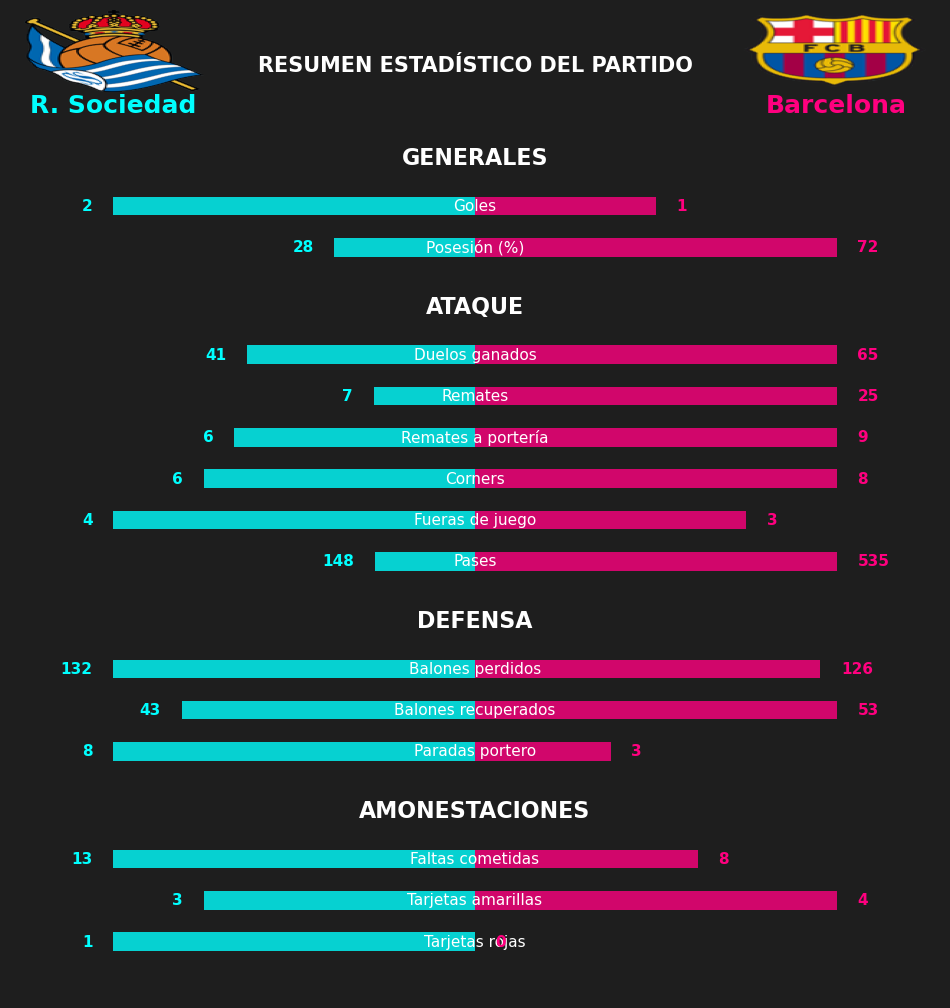

In [39]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# =============================
# COLORES
# =============================
HOME_COLOR = "#00FFFF"   # Neón azul Real Sociedad
AWAY_COLOR = "#FF007F"   # Neón granate Barcelona
BG_COLOR = "#1E1E1E"     # Fondo oscuro
TEXT_COLOR = "#FFFFFF"

# =============================
# CARGAR ESCUDOS
# =============================
def load_logo(url):
    return Image.open(BytesIO(requests.get(url).content))

home_logo = load_logo(
    "https://e01-marca.uecdn.es/assets/sports/logos/football/png/144x144/188.png"
)
away_logo = load_logo(
    "https://e01-marca.uecdn.es/assets/sports/logos/football/png/144x144/178.png"
)

# =============================
# PREPARAR DATOS
# =============================
sections = {
    "GENERALES": {
        "Goles": (int(home_goals), int(away_goals)),
        "Posesión (%)": (int(possession_home.replace("%", "")),
                         int(possession_away.replace("%", ""))),
    },
    "ATAQUE": {},
    "DEFENSA": {},
    "AMONESTACIONES": {}
}

for k, v in stats.items():
    section, name = k.split(" - ", 1)
    sections[section][name] = (int(v[0]), int(v[1]))

# =============================
# CREAR FIGURA
# =============================
fig, ax = plt.subplots(figsize=(12, 16))
fig.patch.set_facecolor(BG_COLOR)
ax.axis("off")

# =============================
# ESCUDOS Y TITULO
# =============================
ax.imshow(home_logo, extent=(0.05, 0.25, 0.92, 1))
ax.imshow(away_logo, extent=(0.75, 0.95, 0.92, 1))

ax.text(0.15, 0.90, home_team, ha="center", fontsize=18,
        color=HOME_COLOR, weight="bold")
ax.text(0.85, 0.90, away_team, ha="center", fontsize=18,
        color=AWAY_COLOR, weight="bold")
ax.text(0.5, 0.94, "RESUMEN ESTADÍSTICO DEL PARTIDO",
        ha="center", fontsize=15, weight="bold", color=TEXT_COLOR)

# =============================
# DIBUJAR BARRAS (centradas)
# =============================
y = 0.85
row_h = 0.04

for section, data in sections.items():
    ax.text(0.5, y, section, ha="center", fontsize=16,
            weight="bold", color=TEXT_COLOR)
    y -= row_h

    for stat, (home_val, away_val) in data.items():
        max_val = max(home_val, away_val, 1)

        # Centrar barras a la izquierda y derecha del texto
        # 0.5 es el centro de la etiqueta
        left_width = - (home_val / max_val) * 0.35
        right_width = (away_val / max_val) * 0.35

        # Barras horizontales
        ax.barh(y, left_width, color=HOME_COLOR, height=0.018, alpha=0.8, left=0.5)
        ax.barh(y, right_width, color=AWAY_COLOR, height=0.018, alpha=0.8, left=0.5)

        # Texto de valores
        ax.text(0.5 + left_width - 0.02, y, str(home_val),
                ha="right", va="center", fontsize=11, color=HOME_COLOR, weight="bold")
        ax.text(0.5, y, stat, ha="center", va="center", fontsize=11, color=TEXT_COLOR)
        ax.text(0.5 + right_width + 0.02, y, str(away_val),
                ha="left", va="center", fontsize=11, color=AWAY_COLOR, weight="bold")

        y -= row_h
    y -= row_h * 0.6  # espacio extra entre secciones

# =============================
# GUARDAR FIGURA
# =============================
# Carpeta donde guardar
import os
output_folder = "infografias partido"
os.makedirs(output_folder, exist_ok=True)  # ✅ Crea la carpeta si no existe

# Guardar figura
plt.savefig(f"{output_folder}/1.statsgenerales.png", 
            dpi=150, bbox_inches="tight", facecolor=BG_COLOR)

## Análisis de pases por zonas horizontales del campo

Este bloque de código genera un **gráfico de barras** que muestra la distribución de los pases realizados por cada equipo en distintas **zonas horizontales del campo**, dividiéndolo en cuatro cuartos desde la defensa hasta el ataque.

A partir de un fichero CSV con eventos del partido, el script:
- Filtra únicamente las acciones correspondientes a pases.
- Determina si cada pase fue exitoso o no.
- Convierte las coordenadas del sistema OPTA a metros reales del terreno de juego.
- Clasifica cada pase según la zona del campo en la que se produjo.

Posteriormente, se crea una función que:
- Cuenta el número de pases por zona para cada equipo.
- Genera un gráfico de barras con un **estilo oscuro tipo neón**, usando colores representativos de cada club.
- Añade el nombre del equipo y su escudo junto al título del gráfico.
- Guarda la visualización final en formato PNG para su inclusión en la entrega.

Este análisis permite comprender de forma visual **dónde se concentra la circulación del balón** de cada equipo a lo largo del partido.


Gráfico guardado en: infografias partido\2.Zona de campo Pases Barcelona.png


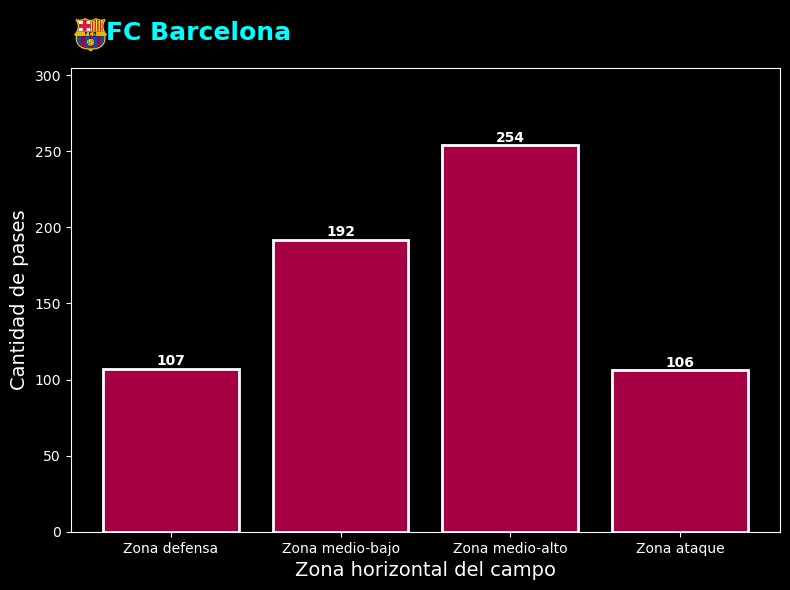

Gráfico guardado en: infografias partido\3.Zona de pases Real Sociedad.png


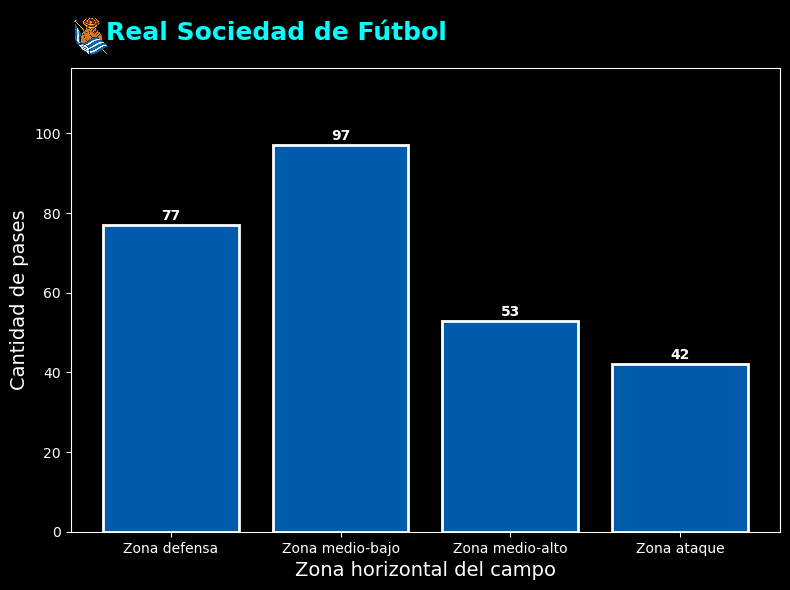

In [43]:
# -*- coding: utf-8 -*-
"""
Gráfico de barras estilo neón: cantidad de pases por zona horizontal (cuartos)
del campo, por equipo, con escudos junto al título, guardado en PNG.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import requests
from io import BytesIO

# ===============================
# 1. CONFIGURACIÓN
# ===============================

CSV_FILE = "result/matchevent_realsociedadvsbaercelona.csv"
PITCH_LENGTH = 105
BG_COLOR = "#020617"  # Fondo oscuro para estilo neón

PASS_OUTCOME_COL = "outcome"  # 1 = éxito, 0 = fallo

TEAM_LOGOS = {
    "FC Barcelona": "https://e01-marca.uecdn.es/assets/sports/logos/football/png/144x144/178.png",
    "Real Sociedad de Fútbol": "https://e01-marca.uecdn.es/assets/sports/logos/football/png/144x144/188.png"
}

TEAM_COLORS = {
    "FC Barcelona": "#A50044",      # granate
    "Real Sociedad de Fútbol": "#005BAC"  # azul
}

# Carpeta donde guardar los gráficos
output_folder = "infografias partido"
os.makedirs(output_folder, exist_ok=True)

# ===============================
# 2. CARGA DE DATOS
# ===============================

df = pd.read_csv(CSV_FILE)

# Filtramos solo pases
df["is_pass"] = df["event"].astype(str).str.contains("pass", case=False, na=False)

# Determinar si fue exitoso
def _is_success(val):
    if pd.isna(val):
        return False
    if isinstance(val, (int, float)):
        return bool(int(val))
    s = str(val).strip().lower()
    return s in {"1", "successful", "success", "complete", "completed", "accurate", "won"}

df["pass_success"] = df[PASS_OUTCOME_COL].apply(_is_success)

# ===============================
# 3. CONVERSIÓN A METROS
# ===============================

def opta_to_meters_x(x): return x * PITCH_LENGTH / 100.0
df["x_m"] = df["x"].clip(0,100).apply(opta_to_meters_x)

# ===============================
# 4. DIVIDIR EL CAMPO EN CUARTOS HORIZONTALES (EJE X)
# ===============================

def assign_x_quarter(x):
    if x <= PITCH_LENGTH/4:
        return "Zona defensa"
    elif x <= PITCH_LENGTH/2:
        return "Zona medio-bajo"
    elif x <= 3*PITCH_LENGTH/4:
        return "Zona medio-alto"
    else:
        return "Zona ataque"

df["x_quarter"] = df["x_m"].apply(assign_x_quarter)

# ===============================
# 5. FUNCIÓN PARA GRAFICAR UN EQUIPO Y GUARDAR PNG
# ===============================

def plot_team_bars(team_name, filename):
    zones = ["Zona defensa", "Zona medio-bajo", "Zona medio-alto", "Zona ataque"]
    team_df = df[(df["team_name"] == team_name) & (df["is_pass"])]
    counts = team_df["x_quarter"].value_counts().reindex(zones, fill_value=0)

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(8,6))
    
    # Barras
    bars = ax.bar(counts.index, counts.values, color=TEAM_COLORS[team_name], edgecolor='white', linewidth=2)
    
    # Valores sobre las barras
    for i, v in enumerate(counts.values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', color='white', fontweight='bold')

    # Configuración de ejes
    ax.set_xlabel("Zona horizontal del campo", fontsize=14, color='white')
    ax.set_ylabel("Cantidad de pases", fontsize=14, color='white')
    ax.set_ylim(0, max(counts.values)*1.2)
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')

    # ===============================
    # Añadir título con logo al lado
    # ===============================
    ax_title_x = 0.05
    ax_title_y = 1.05

    # Título en neón
    ax.text(ax_title_x, ax_title_y, team_name, transform=ax.transAxes, fontsize=18,
            color='cyan', fontweight='bold', va='bottom', ha='left')

    # Logo al lado del título
    logo_url = TEAM_LOGOS.get(team_name)
    if logo_url:
        try:
            response = requests.get(logo_url)
            img = mpimg.imread(BytesIO(response.content))
            imagebox = OffsetImage(img, zoom=0.20)
            ab = AnnotationBbox(imagebox, (ax_title_x - 0.05, ax_title_y+0.02),
                                xycoords='axes fraction', frameon=False,
                                box_alignment=(0,0.5))
            ax.add_artist(ab)
        except Exception as e:
            print(f"No se pudo cargar el logo de {team_name}: {e}")

    plt.tight_layout()

    # Guardar PNG
    filepath = os.path.join(output_folder, filename)
    plt.savefig(filepath, dpi=150, bbox_inches="tight", facecolor=BG_COLOR)
    print(f"Gráfico guardado en: {filepath}")
    plt.show()

# ===============================
# 6. GRAFICAR CADA EQUIPO Y GUARDAR
# ===============================

plot_team_bars("FC Barcelona", "2.Zona de campo Pases Barcelona.png")
plot_team_bars("Real Sociedad de Fútbol", "3.Zona de pases Real Sociedad.png")


## Análisis temporal de los tiros del partido

Este bloque de código se encarga de analizar y visualizar la **distribución temporal de los tiros** realizados por cada equipo a lo largo del partido, utilizando gráficos de barras apiladas con la librería **Plotly**.

En primer lugar, se configuran los parámetros generales del campo de fútbol, los colores representativos de cada equipo y las rutas donde se guardarán las infografías generadas.  
A continuación, se cargan los datos de eventos del partido y un fichero auxiliar de OPTA que permite clasificar cada acción según su tipo (tiro, pase, etc.).

El script:
- Filtra únicamente las acciones correspondientes a **tiros**.
- Convierte las coordenadas del sistema OPTA a metros reales del campo.
- Calcula el minuto absoluto de cada acción.
- Agrupa los tiros en **bloques de 5 minutos**, diferenciando entre tiros exitosos y fallidos.

Posteriormente, se define una función que:
- Genera un gráfico de barras apiladas para cada equipo.
- Aplica un estilo visual oscuro tipo neón.
- Añade el título centrado y el escudo del equipo.
- Guarda la imagen resultante en formato PNG.

Este análisis permite identificar **cuándo se producen los momentos de mayor actividad ofensiva** de cada equipo durante el partido.


In [75]:
# =============================== 
# 1. Configuración 
# =============================== 
import os
import pandas as pd
import numpy as np
import plotly.express as px
import requests
from PIL import Image
from io import BytesIO

PITCH_LENGTH = 105
PITCH_WIDTH = 68

TEAM_COLORS = {
    "FC Barcelona": "#A50044",  # blaugrana
    "Real Sociedad de Fútbol": "#005BAC"  # azul Real Sociedad
}

TEAM_LOGOS = {
    "FC Barcelona": "https://e01-marca.uecdn.es/assets/sports/logos/football/png/144x144/178.png",
    "Real Sociedad de Fútbol": "https://e01-marca.uecdn.es/assets/sports/logos/football/png/144x144/188.png"
}

# Carpeta para guardar infografías
SAVE_DIR = "infografias partido"
os.makedirs(SAVE_DIR, exist_ok=True)

# =============================== 
# 2. Carga y preparación de datos 
# =============================== 
EVENTS_CSV = "result/matchevent_realsociedadvsbaercelona.csv"
OPTA_TYPES_CSV = "opta/opta_event_types_with_categories.csv"

df = pd.read_csv(EVENTS_CSV)
types_df = pd.read_csv(OPTA_TYPES_CSV)

# Columnas relevantes
RELEVANT_COLS = ["period_id", "time_min", "time_sec", "team_name", "player_name", "type_id", "x", "y", "outcome", "event"]
df = df[RELEVANT_COLS].copy()

# Mapeo tipo_id → macro_category
typeid_to_macro = dict(zip(types_df["eventTypeId"], types_df["macro_category"]))
df["type_id_int"] = pd.to_numeric(df["type_id"], errors="coerce").astype("Int64")
df["macro_category"] = df["type_id_int"].map(lambda v: typeid_to_macro.get(int(v), None) if pd.notna(v) else None)

# Normalizar coordenadas a metros
df["x"] = pd.to_numeric(df["x"], errors="coerce")
df["y"] = pd.to_numeric(df["y"], errors="coerce")
df = df.dropna(subset=["x","y"])
df["x_m"] = df["x"] * PITCH_LENGTH / 100.0
df["y_m"] = df["y"] * PITCH_WIDTH / 100.0

# Solo tiros
df_shots = df[df["macro_category"] == "shot"].copy()
df_shots["success"] = df_shots["outcome"] == 1

# Tiempo absoluto
df_shots["minute"] = np.where(df_shots["period_id"].isin([1, 2]), df_shots["time_min"], df_shots["time_min"] + 45)

# Bloques de 5 minutos
bins_5min = list(range(0, 91, 5))
labels_5min = [f"{b}-{b+5}" for b in bins_5min[:-1]]
df_shots["time_block"] = pd.cut(df_shots["minute"], bins=bins_5min, labels=labels_5min, right=False)

# =============================== 
# 3. Función para graficar un equipo con logo y guardar 
# =============================== 
def plot_team_shots(team_name, title, filename):
    df_team = df_shots[df_shots["team_name"] == team_name]
    shots_timeblock = (
        df_team
        .groupby(["time_block", "success"])
        .size()
        .reset_index(name="n_shots")
    )

    # Crear figura
    fig = px.bar(
        shots_timeblock,
        x="time_block",
        y="n_shots",
        color="success",
        barmode="stack",
        labels={
            "success": "Éxito",
            "n_shots": "Cantidad de tiros",
            "time_block": "Minutos"
        },
        color_discrete_map={True: TEAM_COLORS[team_name], False: "#222222"}
    )

    # Estilo neón
    fig.update_layout(
        title=dict(
            text=title,
            font=dict(color="cyan", size=24, family="Arial Black")
        ),
        plot_bgcolor="#0A0A0A",
        paper_bgcolor="#0A0A0A",
        font=dict(color="white"),
        showlegend=True
    )
    fig.update_traces(marker_line_width=2, marker_line_color="white", opacity=0.9)

    # Añadir logo encima del título
    logo_url = TEAM_LOGOS.get(team_name)
    if logo_url:
        try:
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            fig.add_layout_image(
                dict(
                    source=img,
                    xref="paper",
                    yref="paper",
                    x=0,
                    y=1.14,
                    sizex=0.15,
                    sizey=0.15,
                )
            )
        except Exception as e:
            print(f"No se pudo cargar el logo de {team_name}: {e}")

    fig.update_layout(
    title=dict(
        text=title,
        font=dict(color="cyan", size=24, family="Arial Black"),
        x=0.5,            # ← posición horizontal centrada
        xanchor='center'   # ← ancla el título al centro
    ),
    plot_bgcolor="#0A0A0A",
    paper_bgcolor="#0A0A0A",
    font=dict(color="white"),
    showlegend=True
)
    # Guardar la imagen
    save_path = os.path.join(SAVE_DIR, filename)
    fig.write_image(save_path)
    fig.show()
    print(f"Imagen guardada en: {save_path}")

# =============================== 
# 4. Graficar cada equipo con títulos y guardar 
# =============================== 
plot_team_shots("FC Barcelona", "Tiros", "4. Tiros de Barcelona por tiempo del partido.png")
plot_team_shots("Real Sociedad de Fútbol", "Tiros", "5. Tiros de la Real Sociedad por tiempo del partido.png")



Imagen guardada en: infografias partido\4. Tiros de Barcelona por tiempo del partido.png


Imagen guardada en: infografias partido\5. Tiros de la Real Sociedad por tiempo del partido.png


## Visualización espacial de los tiros sobre el campo

Este bloque de código genera una **visualización espacial de los tiros realizados durante el partido**, representándolos directamente sobre un campo de fútbol a escala, utilizando la librería **Plotly Graph Objects**.

En primer lugar, se definen las dimensiones reales del terreno de juego y los estilos visuales de cada equipo, incluyendo colores y símbolos distintos para facilitar la identificación. También se configura la carpeta donde se guardará la imagen final.

A continuación, se cargan los datos de eventos del partido y se clasifican las acciones según su tipo, filtrando únicamente los **tiros**. Las coordenadas OPTA se transforman a metros reales y se normaliza la dirección de ataque, de modo que ambos equipos ataquen visualmente hacia la misma portería, permitiendo una comparación directa.

El código construye posteriormente un **campo de fútbol con estética neón**, dibujando:
- El fondo del campo y franjas sutiles.
- Las líneas reglamentarias del terreno de juego.
- El círculo central, los puntos de penalti y las porterías.

Sobre este campo se superponen los tiros de cada equipo:
- Diferenciando equipos mediante colores y formas.
- Indicando el resultado del tiro (exitoso o fallido) mediante la opacidad.
- Mostrando información contextual del jugador al pasar el cursor.

Finalmente, se ajusta el diseño general, la leyenda y el título, y se guarda la infografía en formato PNG.  
El resultado es una representación clara e intuitiva de **desde dónde se generaron los tiros y cómo se distribuyó el peligro ofensivo** a lo largo del partido.


In [59]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ===============================
# 1. Configuración
# ===============================
PITCH_LENGTH = 105
PITCH_WIDTH  = 68

TEAM_STYLE = {
    "FC Barcelona": {"color": "#A50044", "symbol": "circle"},
    "Real Sociedad de Fútbol": {"color": "#005BAC", "symbol": "square"}
}

SAVE_DIR = "infografias partido"
os.makedirs(SAVE_DIR, exist_ok=True)  # Crear carpeta si no existe

# ===============================
# 2. Carga y preparación de datos
# ===============================
EVENTS_CSV = "result/matchevent_realsociedadvsbaercelona.csv"
OPTA_TYPES_CSV = "opta/opta_event_types_with_categories.csv"

df = pd.read_csv(EVENTS_CSV)
types_df = pd.read_csv(OPTA_TYPES_CSV)

available_cols = df.columns.tolist()
RELEVANT_COLS = [c for c in ["period_id","time_min","team_name","type_id","x","y","outcome","player_name"] if c in available_cols]
df = df[RELEVANT_COLS].copy()

if "eventTypeId" in types_df.columns and "macro_category" in types_df.columns:
    typeid_to_macro = dict(zip(types_df["eventTypeId"], types_df["macro_category"]))
    df["type_id_int"] = pd.to_numeric(df["type_id"], errors="coerce").astype("Int64")
    df["macro_category"] = df["type_id_int"].map(lambda v: typeid_to_macro.get(int(v), None) if pd.notna(v) else None)
else:
    df["macro_category"] = None

df = df.dropna(subset=["x","y"])
df["x_m"] = df["x"] * PITCH_LENGTH / 100.0
df["y_m"] = df["y"] * PITCH_WIDTH / 100.0

df_shots = df[df["macro_category"] == "shot"].copy()
df_shots["success"] = df_shots.get("outcome", 0) == 1

# ===============================
# 3. Normalizar dirección de los tiros
# ===============================
def normalize_shot_direction(df, team_right="FC Barcelona"):
    df = df.copy()
    mask_right = df["team_name"] == team_right
    df.loc[mask_right, "x_plot"] = df.loc[mask_right, "x_m"]
    df.loc[mask_right, "y_plot"] = df.loc[mask_right, "y_m"]
    df.loc[~mask_right, "x_plot"] = PITCH_LENGTH - df.loc[~mask_right, "x_m"]
    df.loc[~mask_right, "y_plot"] = PITCH_WIDTH - df.loc[~mask_right, "y_m"]
    return df

df_shots = normalize_shot_direction(df_shots, team_right="FC Barcelona")

# ===============================
# 4. Crear campo de fútbol estilo neón
# ===============================
fig = go.Figure()


pitch_length = 105
pitch_width = 68

GOAL_WIDTH_M  = 7.32
GOAL_DEPTH_M  = 2.0
GOAL_MARGIN_X = 0.2

# Dark background
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=pitch_length, y1=pitch_width,
    fillcolor="#020617",
    layer="below",
    line=dict(width=0),
)

# Subtle stripes
stripe_width = pitch_length / 12
for i in range(12):
    fig.add_shape(
        type="rect",
        x0=i * stripe_width,
        y0=0,
        x1=(i + 1) * stripe_width,
        y1=pitch_width,
        fillcolor="rgba(56,189,248,0.06)" if i % 2 == 0 else "rgba(37,99,235,0.05)",
        layer="below",
        line=dict(width=0),
    )

# Pitch lines (neon)
field_lines = [
    [[0, 0], [0, pitch_width]],
    [[0, pitch_width], [pitch_length, pitch_width]],
    [[pitch_length, pitch_width], [pitch_length, 0]],
    [[pitch_length, 0], [0, 0]],
    [[pitch_length / 2, 0], [pitch_length / 2, pitch_width]],
    [[16.5, (pitch_width / 2) - 16.5], [16.5, (pitch_width / 2) + 16.5]],
    [[pitch_length - 16.5, (pitch_width / 2) - 16.5],
     [pitch_length - 16.5, (pitch_width / 2) + 16.5]],
    [[0, (pitch_width / 2) - 16.5], [16.5, (pitch_width / 2) - 16.5]],
    [[0, (pitch_width / 2) + 16.5], [16.5, (pitch_width / 2) + 16.5]],
    [[pitch_length, (pitch_width / 2) - 16.5],
     [pitch_length - 16.5, (pitch_width / 2) - 16.5]],
    [[pitch_length, (pitch_width / 2) + 16.5],
     [pitch_length - 16.5, (pitch_width / 2) + 16.5]],
    [[5.5, (pitch_width / 2) - 5.5], [5.5, (pitch_width / 2) + 5.5]],
    [[pitch_length - 5.5, (pitch_width / 2) - 5.5],
     [pitch_length - 5.5, (pitch_width / 2) + 5.5]],
    [[0, (pitch_width / 2) - 5.5], [5.5, (pitch_width / 2) - 5.5]],
    [[0, (pitch_width / 2) + 5.5], [5.5, (pitch_width / 2) + 5.5]],
    [[pitch_length, (pitch_width / 2) - 5.5],
     [pitch_length - 5.5, (pitch_width / 2) - 5.5]],
    [[pitch_length, (pitch_width / 2) + 5.5],
     [pitch_length - 5.5, (pitch_width / 2) + 5.5]],
]

for line in field_lines:
    fig.add_trace(go.Scatter(
        x=[line[0][0], line[1][0]],
        y=[line[0][1], line[1][1]],
        mode="lines",
        line=dict(color="#00f5ff", width=2),
        hoverinfo="skip",
        showlegend=False,
    ))

# Centre circle
circle_x = [pitch_length / 2 + 9.15 * np.cos(t) for t in np.linspace(0, 2*np.pi, 200)]
circle_y = [pitch_width / 2 + 9.15 * np.sin(t) for t in np.linspace(0, 2*np.pi, 200)]

fig.add_trace(go.Scatter(
    x=circle_x,
    y=circle_y,
    mode="lines",
    line=dict(color="#00f5ff", width=2),
    hoverinfo="skip",
    showlegend=False,
))

# Centre spot and penalty spots
fig.add_trace(go.Scatter(
    x=[pitch_length/2, 11, pitch_length-11],
    y=[pitch_width/2, pitch_width/2, pitch_width/2],
    mode="markers",
    marker=dict(color="#f9fafb", size=6),
    hoverinfo="skip",
    showlegend=False,
))

# ==========================
# GOALS (neon)
# ==========================
goal_center_y = pitch_width / 2.0
goal_half_w = GOAL_WIDTH_M / 2.0
goal_y_bottom = goal_center_y - goal_half_w
goal_y_top = goal_center_y + goal_half_w

box_color = "#00ffa3"

# Right goal
goal_right_x_front = pitch_length - GOAL_MARGIN_X
goal_right_x_back  = goal_right_x_front - GOAL_DEPTH_M

for (x0, y0, x1, y1) in [
    (goal_right_x_front, goal_y_bottom, goal_right_x_back,  goal_y_bottom),
    (goal_right_x_front, goal_y_top,    goal_right_x_back,  goal_y_top),
    (goal_right_x_back,  goal_y_bottom, goal_right_x_back,  goal_y_top),
]:
    fig.add_shape(
        type="line",
        x0=x0, y0=y0, x1=x1, y1=y1,
        line=dict(color=box_color, width=3),
        layer="above"
    )

# Left goal
goal_left_x_front = 0.0 + GOAL_MARGIN_X
goal_left_x_back  = goal_left_x_front + GOAL_DEPTH_M

for (x0, y0, x1, y1) in [
    (goal_left_x_front, goal_y_bottom, goal_left_x_back,  goal_y_bottom),
    (goal_left_x_front, goal_y_top,    goal_left_x_back,  goal_y_top),
    (goal_left_x_back,  goal_y_bottom, goal_left_x_back,  goal_y_top),
]:
    fig.add_shape(
        type="line",
        x0=x0, y0=y0, x1=x1, y1=y1,
        line=dict(color=box_color, width=3),
        layer="above"
    )

fig.update_layout(
    title=dict(
        text="Football Pitch – Neon night with goals",
        font=dict(color="#e5e7eb")
    ),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        scaleanchor="x",
        scaleratio=1
    ),
    plot_bgcolor="#020617",
    paper_bgcolor="#020617",
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=40, b=20),
)

# ===============================
# 5. Añadir tiros por equipo
# ===============================
for team, style in TEAM_STYLE.items():
    for success, opacity in zip([True, False], [0.9, 0.5]):
        df_plot = df_shots[(df_shots["team_name"]==team) & (df_shots["success"]==success)]
        if df_plot.empty:
            continue
        fig.add_trace(go.Scatter(
            x=df_plot["x_plot"],
            y=df_plot["y_plot"],
            mode="markers",
            marker=dict(
                size=10,
                color=style["color"],
                symbol=style["symbol"],
                opacity=opacity,
                line=dict(color="black", width=0.5)
            ),
            name=f"{team} – {'Gol/Tiro a puerta' if success else 'Fallo'}",
            hovertemplate="<b>%{text}</b><br>X: %{x:.1f} m<br>Y: %{y:.1f} m<extra></extra>",
            text=df_plot.get("player_name", ["Sin nombre"]*len(df_plot))
        ))

# ===============================
# 6. Layout y guardar
# ===============================
fig.update_layout(
    title=dict(
        text="Zona de tiros por equipo",
        font=dict(color="#e5e7eb")
    ),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        scaleanchor="x",
        scaleratio=1
    ),
    plot_bgcolor="#020617",
    paper_bgcolor="#020617",
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=40, b=20),
)
fig.update_layout(
    legend=dict(
        font=dict(
            color="white",  # ← aquí pones el color
            size=12
        )
    )
)

fig.update_layout(
    legend=dict(
        x=0.5,      # posición horizontal (0 a 1 para dentro del plot, >1 sale afuera)
        y=1.1,         # posición vertical (0 a 1)
        xanchor="left",  # cómo se ancla la coordenada x
        yanchor="top",   # cómo se ancla la coordenada y
        font=dict(color="white", size=12),
        bgcolor="rgba(0,0,0,0)"  # fondo transparente de la leyenda
    )
)
# Guardar la figura en la carpeta de infografías
save_path = os.path.join(SAVE_DIR, "6.Zona de tiros por equipo.png")
fig.write_image(save_path)
fig.show()
print(f"Imagen guardada en: {save_path}")


Imagen guardada en: infografias partido\6.Zona de tiros por equipo.png
